In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import pairwise_distances
from scipy.spatial import KDTree

In [31]:
import numpy as np

class dCrawler: #changed to fit the name / description
    def __init__(self, threshold=1.0, max_iterations=1000, tolerance=1e-6): #tolerance is the minimum difference between centroids to stop the algorithm, n.all error fix
        self.threshold = threshold
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.centroids = None
        self.cluster_ids = None
    
    def fit(self, X):
        n_samples = X.shape[0]
        centroids = [X[0]]
        cluster_ids = np.zeros(n_samples, dtype=int)
        
        for iteration in range(self.max_iterations):
            cluster_ids, centroids = self._assign_clusters(X, centroids) #crawl? - suggest rename to fit documentation description i.e. self._crawl
            new_centroids = self._update_centroids(X, cluster_ids, centroids)   
            
            centroids_array = np.array(centroids)
            new_centroids_array = np.array(new_centroids)
            
            if np.all(np.abs(centroids_array - new_centroids_array) < self.tolerance):
                break
            
            centroids = new_centroids
        
        cluster_ids, centroids = self._merge_clusters(X, cluster_ids, centroids) #This should be in the loop too. After merging you need to check that the cluster hasn't become enormous
        
        self.centroids = np.array(centroids)
        self.cluster_ids = cluster_ids
        
        return self
    
    def predict(self, X):
        if self.centroids is None:
            raise ValueError("dCrawler has not been fitted yet. Call 'fit' with appropriate arguments before using this method.")
        
        distances = self._calculate_distances(X, self.centroids)
        nearest_clusters = np.argmin(distances, axis=1)
        
        return nearest_clusters + 1
    
    def _assign_clusters(self, X, centroids): #rename to crawl
        n_samples = X.shape[0]
        cluster_ids = np.zeros(n_samples, dtype=int)
        
        for i in range(n_samples):
            distances = self._calculate_distances(X[i], centroids)
            nearest_cluster = np.argmin(distances)
            
            if distances[nearest_cluster] <= self.threshold:
                cluster_ids[i] = nearest_cluster + 1
            else:
                cluster_ids[i] = len(centroids) + 1
                centroids.append(X[i])
        #This is looping through the points 1 by 1 and assigning it to the nearest cluster. dCrawler, assigns the nearest point to the current cluster. Until all points are accounted for
        ### SUGGESTED PSEUDOCODE STEPS ###
        # m = 0 - m is the cluster counter
        #CurrentCluster = m
        #i = 0 starting point for the points
        # assign i to CurrentCluster
        # While there are points without a cluster
        #   Are all points assigned to the cluster still within the threshold?
        #       If no, 
        #           remove those points from the cluster
        #           update the centroid position
        #   Find the closest unassigned point to the current cluster
        #   Is this unassigned point within the threshold?
        #       If yes,
        #           assign the point to the cluster
        #           update the centroid position    
        #       If no,
        #           m += 1
        #           assign the next unassigned point to cluster m
        return cluster_ids, centroids
    
    def _update_centroids(self, X, cluster_ids, centroids):
        new_centroids = []
        unique_clusters = np.unique(cluster_ids)
        
        for cluster in unique_clusters:
            cluster_points = X[cluster_ids == cluster]
            new_centroid = np.mean(cluster_points, axis=0)
            new_centroids.append(new_centroid)
        
        return new_centroids
    
    def _merge_clusters(self, X, cluster_ids, centroids):
        n_clusters = len(centroids)
        merged = True
        
        while merged:
            merged = False
            
            for i in range(n_clusters):
                if centroids[i] is None:
                    continue
                
                for j in range(i + 1, n_clusters):
                    if centroids[j] is None:
                        continue
                    
                    if self._euclidean_distance(centroids[i], centroids[j]) <= self.threshold:
                        # Merge clusters i and j
                        cluster_ids[cluster_ids == j + 1] = i + 1
                        centroids[j] = None
                        merged = True
            
            # Update centroids after merging
            new_centroids = self._update_centroids(X, cluster_ids, centroids)
            centroids = [centroid for centroid in new_centroids if centroid is not None]
            n_clusters = len(centroids)
        
        return cluster_ids, centroids
    
    def _calculate_distances(self, X, centroids):
        distances = []
        for centroid in centroids: #Isn't this a very slow method in a loop? Suggest matrix multiplication might be faster. 
            if centroid is not None:
                distance = self._euclidean_distance(X, centroid)
                distances.append(distance)
            else:
                distances.append(np.inf)
        
        return np.array(distances)
    
    @staticmethod
    def _euclidean_distance(point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

In [2]:
import pandas as pd
data_path = "../DemoData/demodata.csv"
df = pd.read_csv(data_path)
df.head()

,x,y,Cluster
0,1.179043,2.344553,1
1,1.610684,2.242053,1
2,0.247804,1.898954,1
3,1.287104,2.097859,1
4,1.106149,1.737835,1


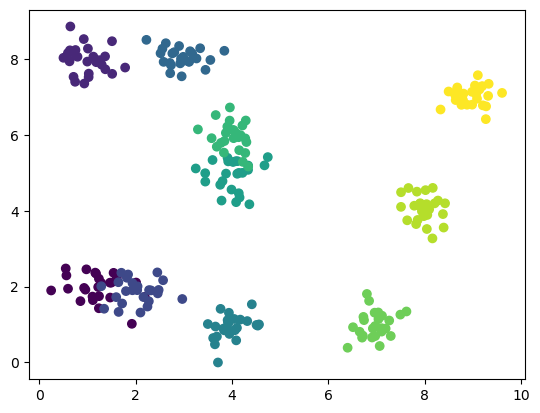

In [4]:
# Plotting here to show the ground truth
import matplotlib.pyplot as plt
fig = plt.gcf()
ax = fig.gca()
plt.scatter(df['x'],df['y'],c=df['Cluster'])

Note that there are two clusters with centroids at (1,2) and (2,2)

In [33]:
data = df.to_numpy()[:,:2]
print(data[:5,:])

[[1.17904316 2.34455277]
 [1.61068371 2.24205275]
 [0.247804   1.89895417]
 [1.28710372 2.0978592 ]
 [1.10614882 1.73783483]]


In [39]:
import matplotlib.pyplot as plt
def plot_crawler_state(data, cluster_list, centroids, threshold):
    # Inputs
    # data = the x,y positions of the data
    # cluster_list = the list of clusters that the points belong to
    # centroids = the centroid of the clusters
    # threshold = the th(d) value used by dCrawler

    # Use an existing figure
    fig = plt.gcf()
    ax = fig.gca()
    n_clust = np.max(cluster_list)

    for i in range(n_clust + 1):
        if i == 0:
            # Unassigned points
            idx = [pt == i for pt in cluster_list]
            points = data[idx, :]
            lab = 'Unassigned Points'
            plt.scatter(points[:, 0], points[:, 1], c='grey', label=lab)
        else:
            lab = f"Cluster {i}"
            idx = [pt == i for pt in cluster_list]
            points = data[idx, :]
            plt.scatter(points[:, 0], points[:, 1], label=lab)

            if i <= len(centroids):
                # Plot registered mean
                plt.scatter(centroids[i - 1][0], centroids[i - 1][1], marker='X',c='r')

                # Calculated mean
                cent = np.mean(points, 0)
                pos = [cent[0], cent[1]]
                plt.scatter(pos[0], pos[1], marker='D', c='y')

                # Plot radius of thresholds
                r = plt.Circle((centroids[i - 1][0], centroids[i - 1][1]), threshold, fill=False, linestyle='--')
                ax.add_patch(r)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [35]:
th_range = [0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 5]
print(len(th_range))
print(th_range)

8
[0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 5]


In [36]:
dcrawler = DCrawler()
clusters = []
cents = []
for th in th_range:
    dcrawler.threshold = th
    dcrawler.fit(data)
    clusters.append(dcrawler.cluster_ids)
    cents.append(dcrawler.centroids)

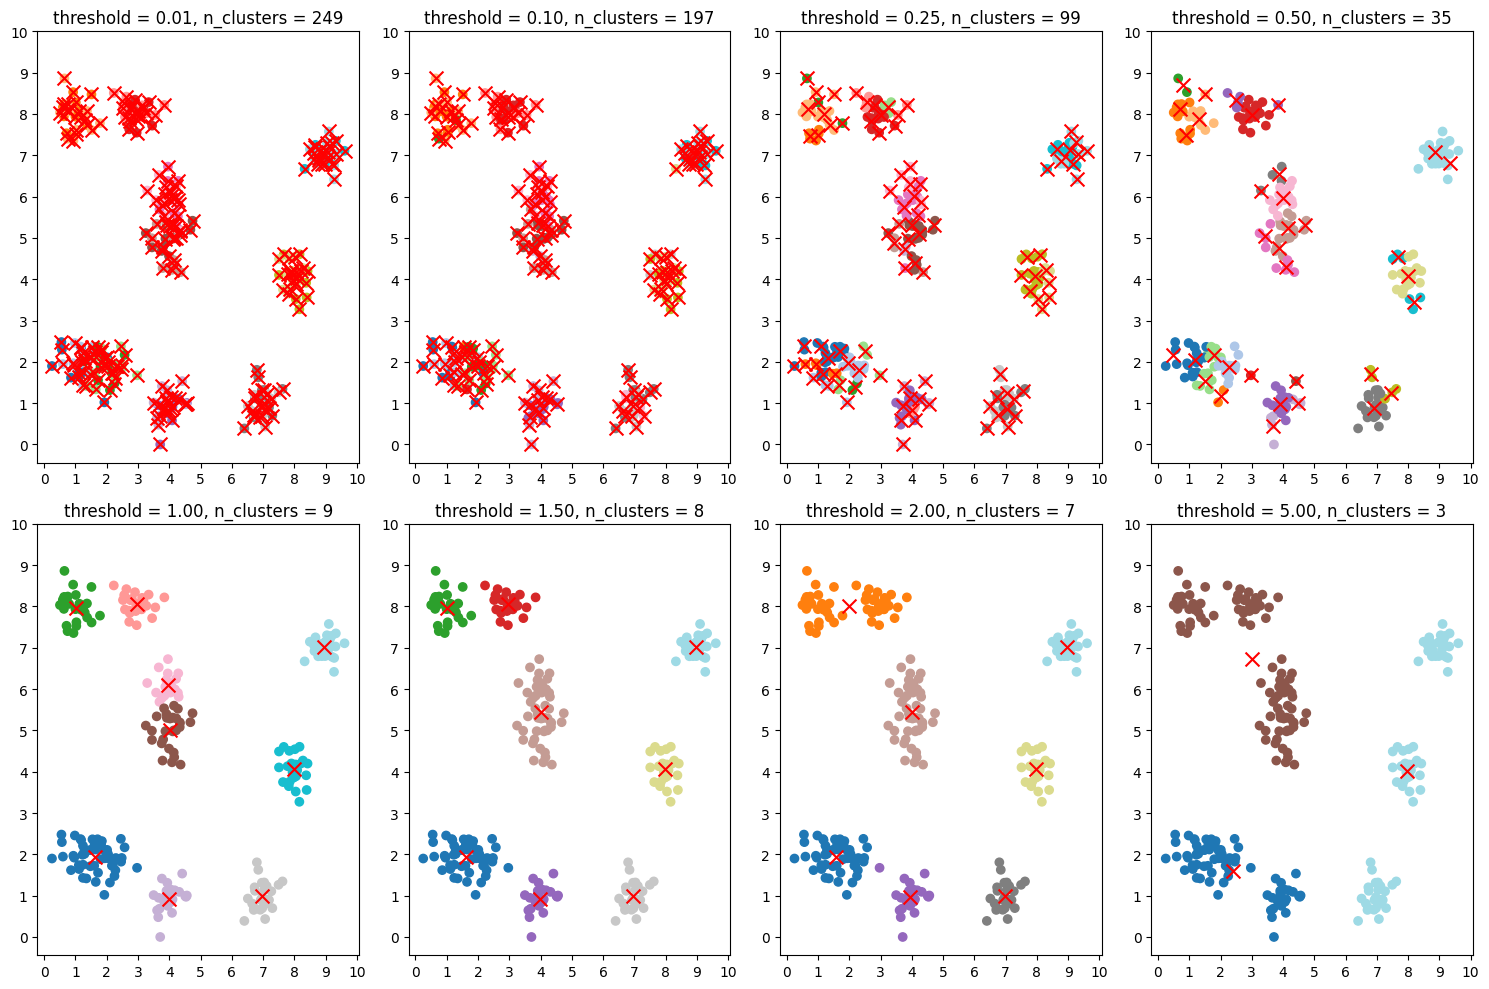

In [37]:
fig,ax = plt.subplots(2, int(len(th_range)/2), figsize=(15, 10))
row,col = 0,0
for i, clus in enumerate(clusters):
    ax[row,col].scatter(data[:,0], data[:,1], c=clus, cmap='tab20')
    ax[row,col].scatter(np.array(cents[i])[:,0], np.array(cents[i])[:,1], c='r', marker='x', s=100)
    ax[row,col].set_title(f'threshold = {th_range[i]:.2f}, n_clusters = {len(set(clus))}')
    ax[row,col].set_xticks(np.linspace(0, 10, 11))
    ax[row,col].set_yticks(np.linspace(0, 10, 11))
    col += 1
    if col >= int(len(th_range)/2):
        row += 1
        col = 0
plt.tight_layout()
plt.show();

At th=1 (the optimum one I had in mind). This doesn't match the MATLAB code

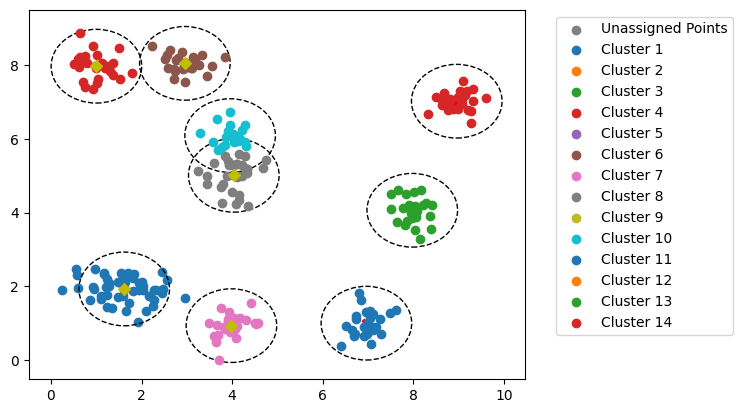

In [41]:
dcrawler.threshold = 1
cluster_list = dcrawler.fit(data)
plot_crawler_state(data, dcrawler.cluster_ids, dcrawler.centroids, dcrawler.threshold)
plt.show();

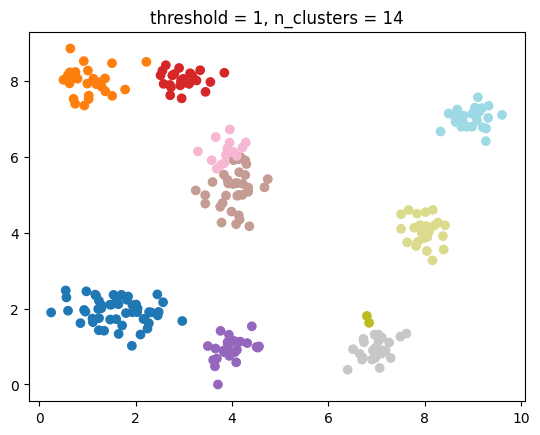

In [16]:
plt.scatter(data[:,0], data[:,1], c=cluster_list, cmap='tab20')
plt.title(f'threshold = {dcrawler.threshold}, n_clusters = {len(set(cluster_list))}')
plt.show();

In [23]:
# Generate sample data
data = np.concatenate([
    np.random.randn(50, 2) + [0, 0],
    np.random.randn(50, 2) + [5, 5],
    np.random.randn(50, 2) + [10, 10]
])

In [24]:
th = 1.0
dc = DCrawlerKDTree(th)
labels = dc.fit_predict(data)

IndexError: index 149 is out of bounds for axis 0 with size 149

In [17]:
import pandas as pd 

In [18]:
df = pd.read_csv('demodata.csv')
df.head()

,x,y,Cluster
0,1.179043,2.344553,1
1,1.610684,2.242053,1
2,0.247804,1.898954,1
3,1.287104,2.097859,1
4,1.106149,1.737835,1


In [19]:
X = df[['x', 'y']].values

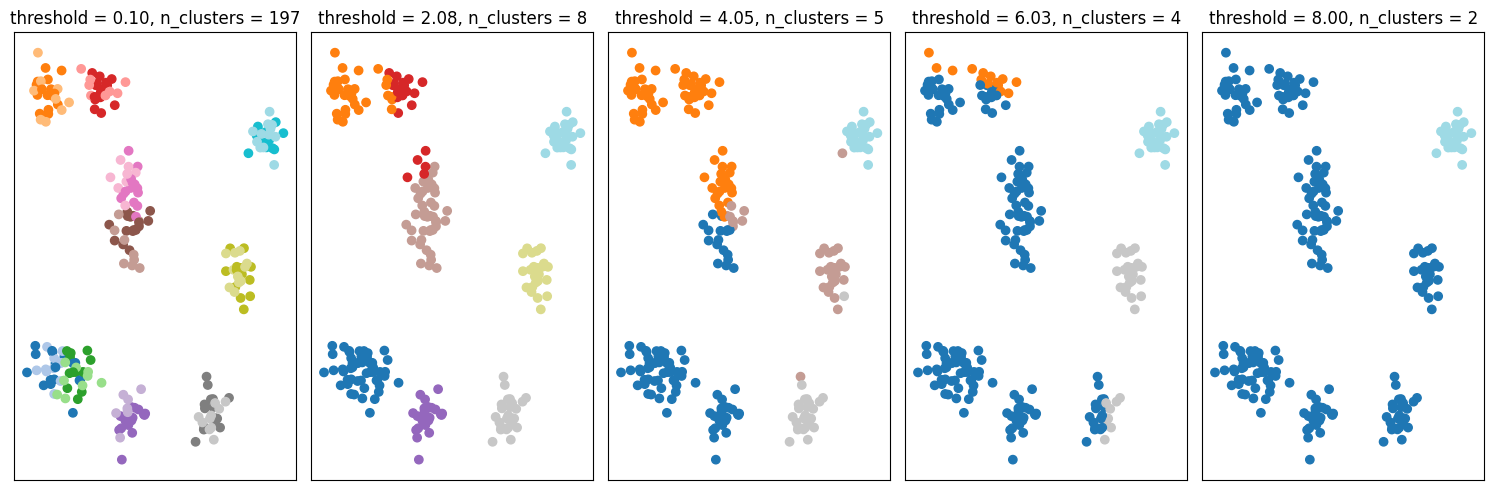

In [21]:
dcrawler = DCrawler()
th_range = np.linspace(0.1, 8, 5)
clusterings = []
for th in th_range:
    dcrawler.threshold = th
    labels = dcrawler.fit_predict(X)
    clusterings.append(labels)

fig,ax = plt.subplots(1, len(th_range), figsize=(15, 5))
for i, clusters in enumerate(clusterings):
    ax[i].scatter(X[:,0], X[:,1], c=clusters, cmap='tab20')
    ax[i].set_title(f'threshold = {th_range[i]:.2f}, n_clusters = {len(set(clusters))}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show();

In [22]:
true_labels = df['Cluster'].values
from sklearn.metrics import adjusted_rand_score

for i, clusters in enumerate(clusterings):
    print(f'threshold = {th_range[i]:.2f}, ARI = {adjusted_rand_score(true_labels, clusters):.2f}')

threshold = 0.10, ARI = 0.03
threshold = 2.08, ARI = 0.75
threshold = 4.05, ARI = 0.40
threshold = 6.03, ARI = 0.13
threshold = 8.00, ARI = 0.05


# Read demo - I suggest we put this in a separate notebook and work on it later.
One idea is to pull the human pancreas gene expression data from the Pancreas and see if we can see the cell types, i.e. identify the alpha and beta islet of langerhans cells - source https://www.gaultonlab.org/pages/Islet_expression_HPAP.html - NB will have to convert from R object.

ALternatively could try GTEx

In [134]:
gene_exp = pd.read_csv('Breast_GSE45827.csv')
gene_exp.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [135]:
X = gene_exp.iloc[:, 2:].values  # Exclude the 'samples' and 'type' columns

In [136]:
threshold = 0.5  # Adjust the threshold value based on your data and desired clustering granularity
dCrawler = DCrawler(threshold=threshold)

In [137]:
labels = dCrawler.fit_predict(X)

In [138]:
len(np.unique(labels))

151

In [139]:
gene_exp['Cluster'] = labels

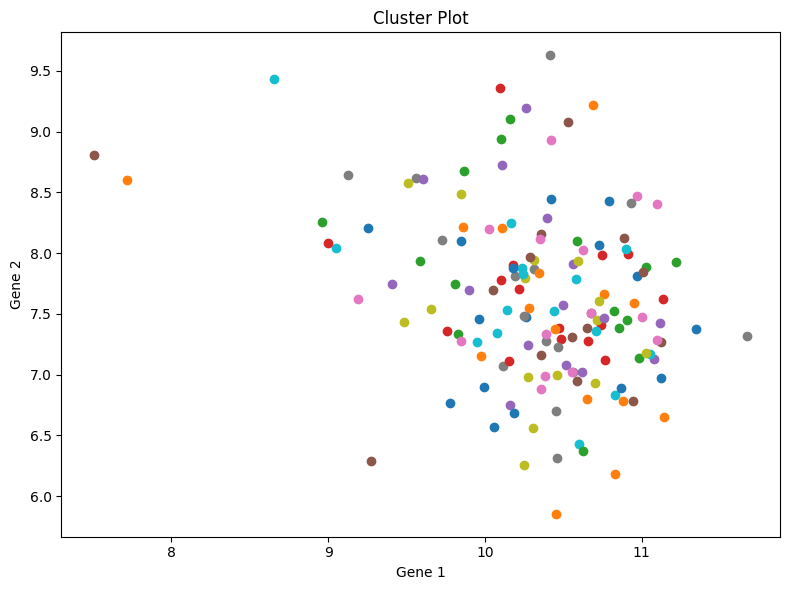

In [151]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster_id in np.unique(labels):
    cluster_data = gene_exp[gene_exp['Cluster'] == cluster_id]
    plt.scatter(cluster_data.iloc[:, 2], cluster_data.iloc[:, 3], label=f'Cluster {cluster_id+1}')

plt.xlabel('Gene 1')
plt.ylabel('Gene 2')
plt.title('Cluster Plot')
plt.tight_layout()
plt.show()

In [141]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [142]:
pca_data = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_data['Cluster'] = labels

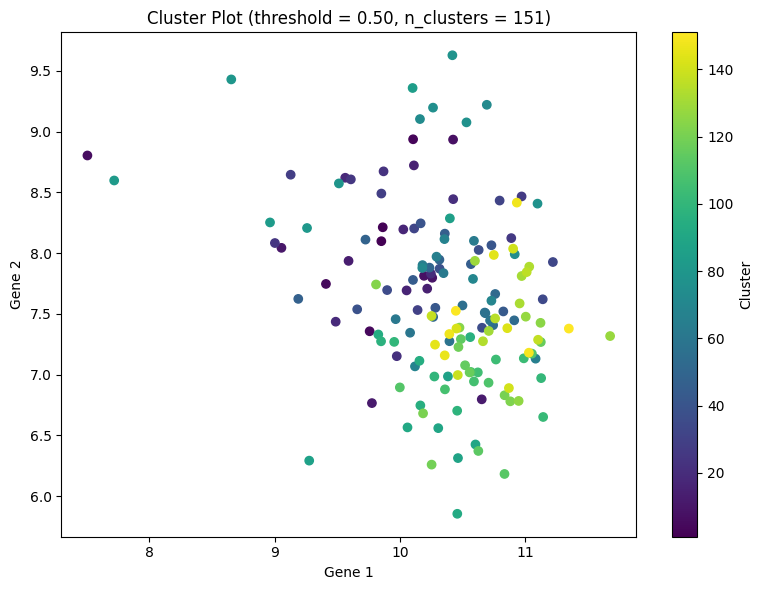

In [157]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel('Gene 1')
plt.ylabel('Gene 2')
plt.title(f'Cluster Plot (threshold = {threshold:.2f}, n_clusters = {len(np.unique(labels))})')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()